# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 0: Load The Data

In [26]:
import importlib
import traffic_data
import numpy as np
from IPython.display import display, Image, HTML

_ = importlib.reload(traffic_data)

In [ ]:
train_file = "data/train.p"
test_file = "data/test.p"

X_train, y_train, X_test, y_test = traffic_data.read(train_file, test_file)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:


# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Shape of an traffic sign image?
image_shape = X_train.shape[1:]

# Unique classes/labels there are in the dataset.
n_classes = np.unique(np.append(y_train, y_test)).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Let's explore dataset which has been loaded.
You can find images of each class below. I didn't try to select perfect images from dataset, so that you could see diversity of the traffic sign samples and their quality. Some examples are even hardly recognizable, e.g. traffic sign with class index **19**, because of its low brightness. Not only color and scale distortions catch the eye, but a part of classes are symmetrically equal. E.g. classes **36** and **37**, if you flip one of them horizontally you will get another one class.

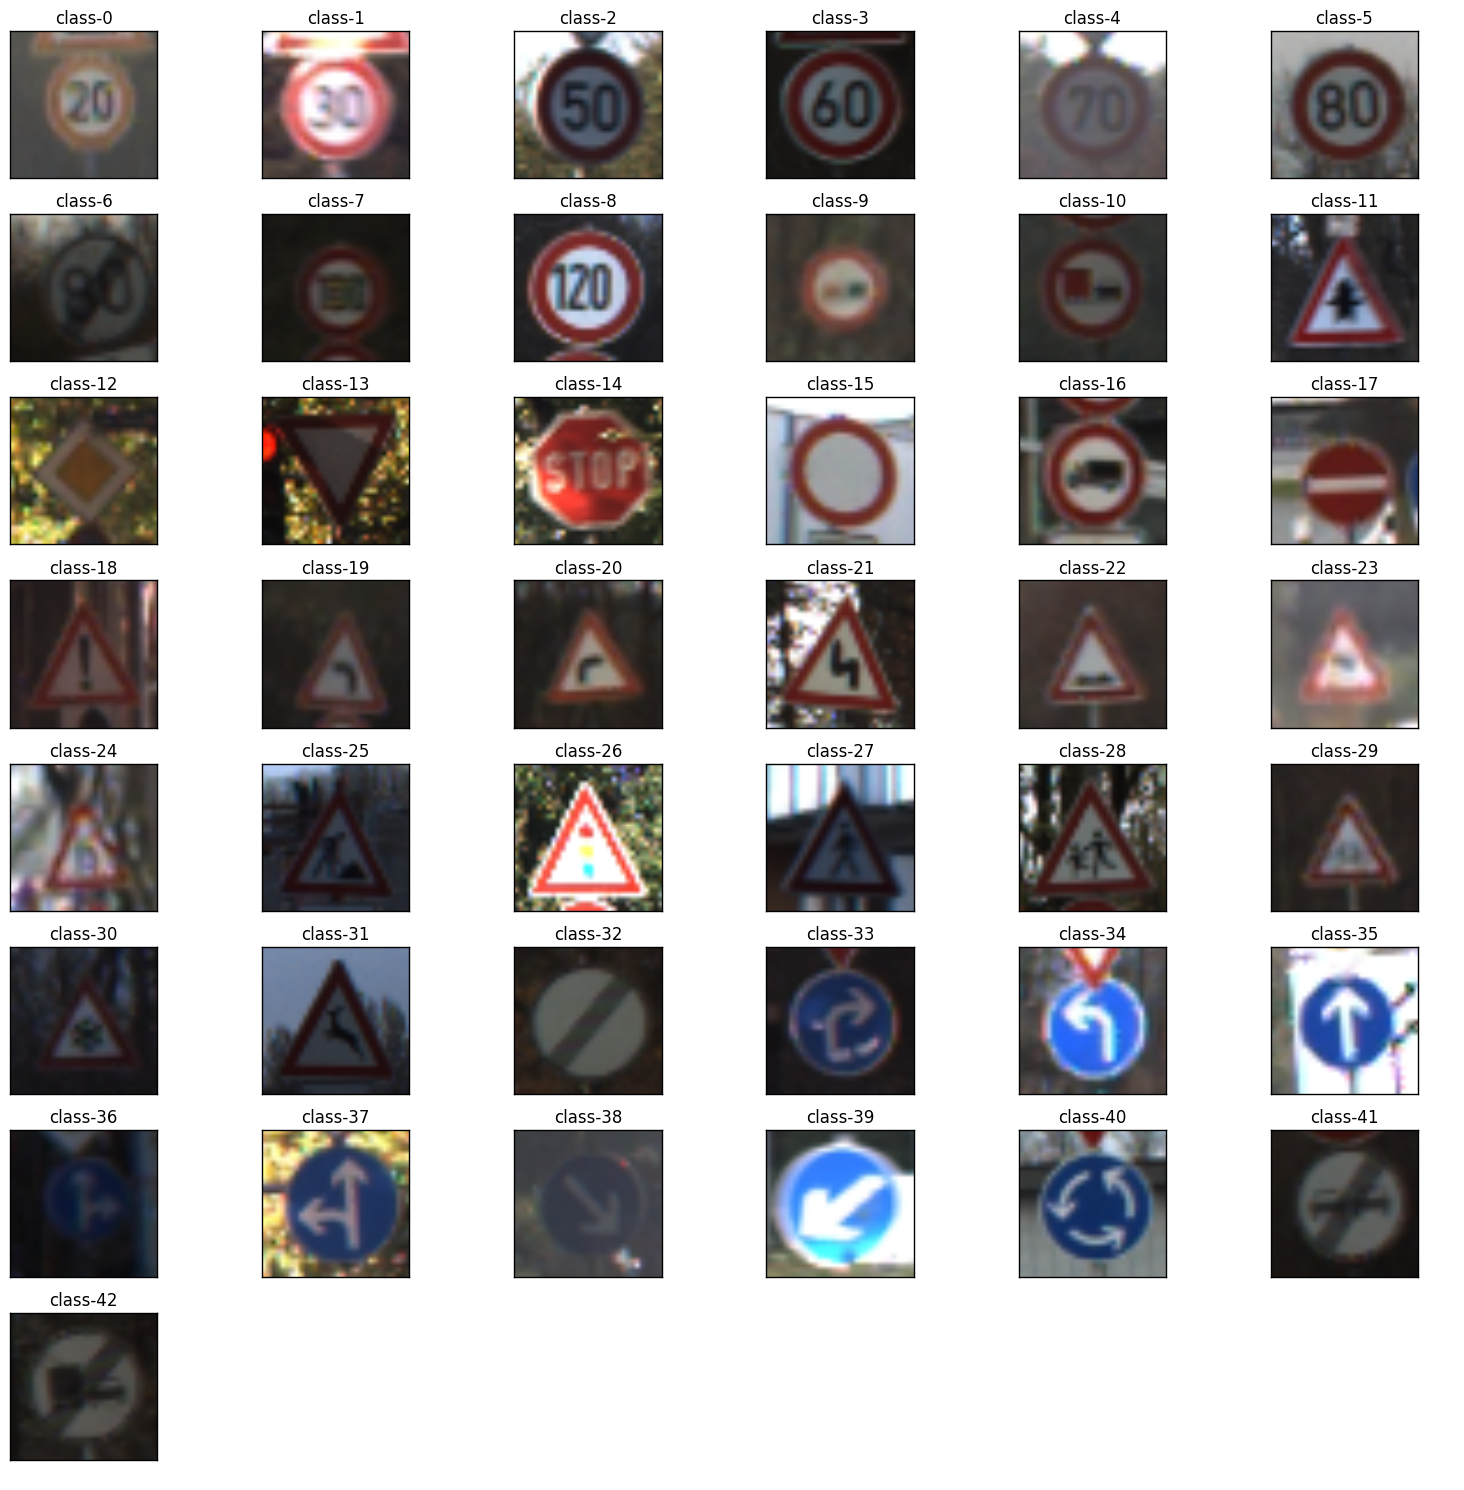

In [23]:
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

sorted_indices = np.argsort(y_train)
diff = np.diff(np.take(y_train, sorted_indices))

class_first_indices = np.append([0], np.add(np.where(diff > 0), 1))

# Stride number is a shift of indices of the class in sorted array of indexes
# Tuning it you can find samples with better quality
stride = 50
class_first_indices_with_shift = class_first_indices + stride
class_indices = np.take(sorted_indices, class_first_indices_with_shift)

# We expect that number of classes in training set is equal to
# total number of classes
assert(class_indices.size == n_classes)

class_images = X_train[class_indices]
class_types = y_train[class_indices]

rows = cols = np.int(np.floor(np.sqrt(n_classes)))
rows += 2
figsize = (15, 15)

_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
for r in np.arange(rows):
    for c in np.arange(cols):
        i = r * cols + c
        if i >= n_classes:
            axes[r][c].axis('off')
            continue
        axes[r][c].imshow(class_images[i])
        axes[r][c].set_title("class-" + str(class_types[i]))
        axes[r][c].get_xaxis().set_visible(False)
        axes[r][c].get_yaxis().set_visible(False)

plt.tight_layout()

Before start learning process, it is important to figure out the distribution of labels in training dataset. Doing so, we will be aware of skewness and bias of dataset to certain labels. Bear in mind that we keep testing dataset in the background as we will not use it during training sessions. 

In [4]:
import pandas as pd

# Pandas sort function emits annoying warning message that columns
# argument is depricated. This trick lets shut it up.
import warnings
warnings.filterwarnings('ignore')

descr_train = traffic_data.label_description(y_train)
descr_test = traffic_data.label_description(y_test)

css = """
div.cell:nth-child(5) .output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(css))

pd.options.display.float_format = '{:.3f}%'.format
display(descr_train)
display(descr_test)

,class,count,percentage
0,2,2250,0.057%
1,1,2220,0.057%
2,13,2160,0.055%
3,12,2100,0.054%
4,38,2070,0.053%
5,10,2010,0.051%
6,4,1980,0.050%
7,5,1860,0.047%
8,25,1500,0.038%
9,9,1470,0.037%


,class,count,percentage
0,2,750,0.059%
1,13,720,0.057%
2,1,720,0.057%
3,38,690,0.055%
4,12,690,0.055%
5,10,660,0.052%
6,4,660,0.052%
7,5,630,0.050%
8,25,480,0.038%
9,9,480,0.038%


The **histogram** shows how fla

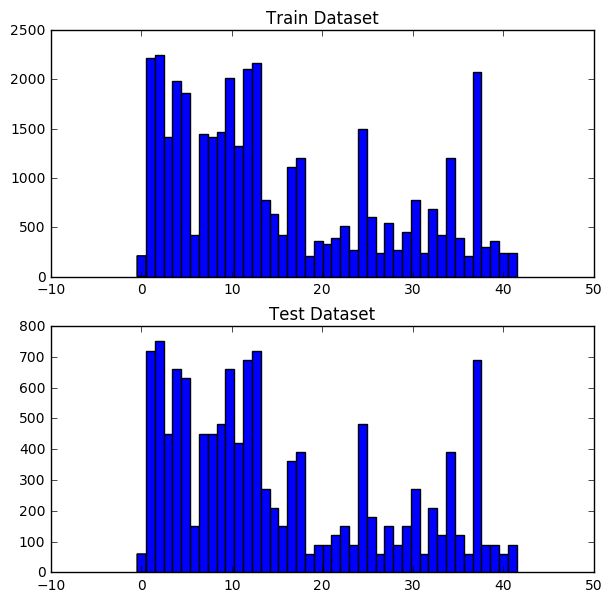

In [5]:
_, ax = plt.subplots(nrows=2, figsize=(7,7))
ax[0].hist(y_train, n_classes, normed=0, histtype='bar', align='left')
ax[1].hist(y_test, n_classes, normed=0, histtype='bar', align='left')
ax[0].set_title("Train Dataset")
_ = ax[1].set_title("Test Dataset")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have 
completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

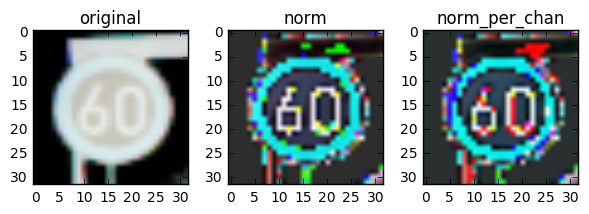

In [6]:
def immean(img):
    return np.mean(img)

def imstd(img):
    num = 1.0
    for x in img.shape: num *= x
    return max(np.std(img), 1.0/(np.sqrt(num)))

def norm(img):
    return (img - immean(img)) / imstd(img)

def immean_per_channel(img):
    return np.mean(img, axis=(0,1))

def imstd_per_channel(img):
    num = img.shape[0] * img.shape[1]
    sqrts = [1.0/np.sqrt(num)] * img.shape[2]
    stds = np.std(img, axis=(0,1))
    return list(map(max, zip(stds, sqrts)))

def norm_per_channel(img):
    return (img - immean_per_channel(img)) / imstd_per_channel(img)

image_index = 5000
train_image = X_train[image_index]

train_image = np.array(train_image, dtype=np.float32)
norm_chan_image = norm_per_channel(train_image)
norm_image = norm(train_image)

examples = [("original", train_image),
            ("norm", norm_image),
            ("norm_per_chan", norm_chan_image)]

_, axes = plt.subplots(ncols=len(examples), squeeze=True)
for i, ax in enumerate(axes):
    ax.set_title(examples[i][0])
    ax.imshow(examples[i][1])

plt.tight_layout()

**Answer:**

In [7]:
# Fraction defines how many new samples should be generated comparatively original dataset
fraction = 1
# Train augmentation size
aug_size = int(n_train * fraction)

xaug, yaug = traffic_data.augment(X_train, y_train, aug_size)

assert(xaug.shape[0] == yaug.shape[0])
print("Number of augmented images: ", yaug.shape[0])

Number of augmented images:  39209


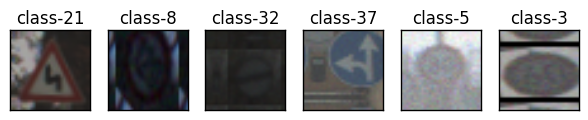

In [8]:
examples_num = 6

_, axes = plt.subplots(ncols=examples_num, squeeze=True)

stride = 1000
for i, ax in enumerate(axes):
    ax.imshow(xaug[i + stride])
    ax.set_title("class-{0}".format(yaug[i + stride]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()

In [9]:
xnew = np.concatenate((X_train, xaug), axis=0)
ynew = np.concatenate((y_train, yaug), axis=0)

In [10]:
# Number of augmented training examples
num_new = xnew.shape[0]

print("Total number of augmented training examples =", num_new)

Total number of augmented training examples = 78418


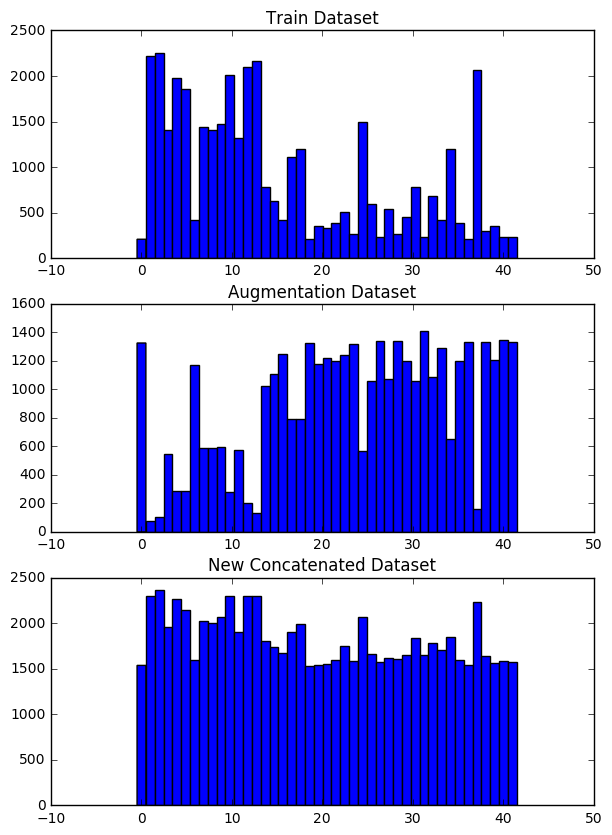

In [12]:
_, ax = plt.subplots(nrows=3, figsize=(7,10))
ax[0].hist(y_train, n_classes, normed=0, histtype='bar', align='left')
ax[1].hist(yaug, n_classes, normed=0, histtype='bar', align='left')
ax[2].hist(ynew, n_classes, normed=0, histtype='bar', align='left')
ax[0].set_title("Train Dataset")
ax[1].set_title("Augmentation Dataset")
_ = ax[2].set_title("New Concatenated Dataset")

In [13]:
descr_new = traffic_data.label_description(ynew)

pd.options.display.float_format = '{:.3f}%'.format
display(descr_new)

,class,count,percentage
0,2,2358,0.030%
1,12,2300,0.029%
2,1,2297,0.029%
3,13,2296,0.029%
4,10,2292,0.029%
5,4,2264,0.029%
6,38,2233,0.028%
7,5,2148,0.027%
8,25,2071,0.026%
9,9,2068,0.026%


In [16]:
shapes = traffic_data.save_for_training(xnew, ynew, X_test, y_test,
                                        model_dir="tf-data",
                                        valid_size=0.1,
                                        override=True)
print("Shape of training dataset: x={0}, y={1}".format(shapes[0], shapes[1]))
print("Shape of validation dataset: x={0}, y={1}".format(shapes[2], shapes[3]))

0-th input is proccessed
10000-th input is proccessed
0-th input is proccessed
10000-th input is proccessed
0-th input is proccessed
10000-th input is proccessed
0-th input is proccessed
10000-th input is proccessed
0-th input is proccessed
0-th input is proccessed
10000-th input is proccessed
Shape of training dataset: x=(70576, 32, 32, 3), y=(70576,)
Shape of validation dataset: x=(7842, 32, 32, 3), y=(7842,)


TODO

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

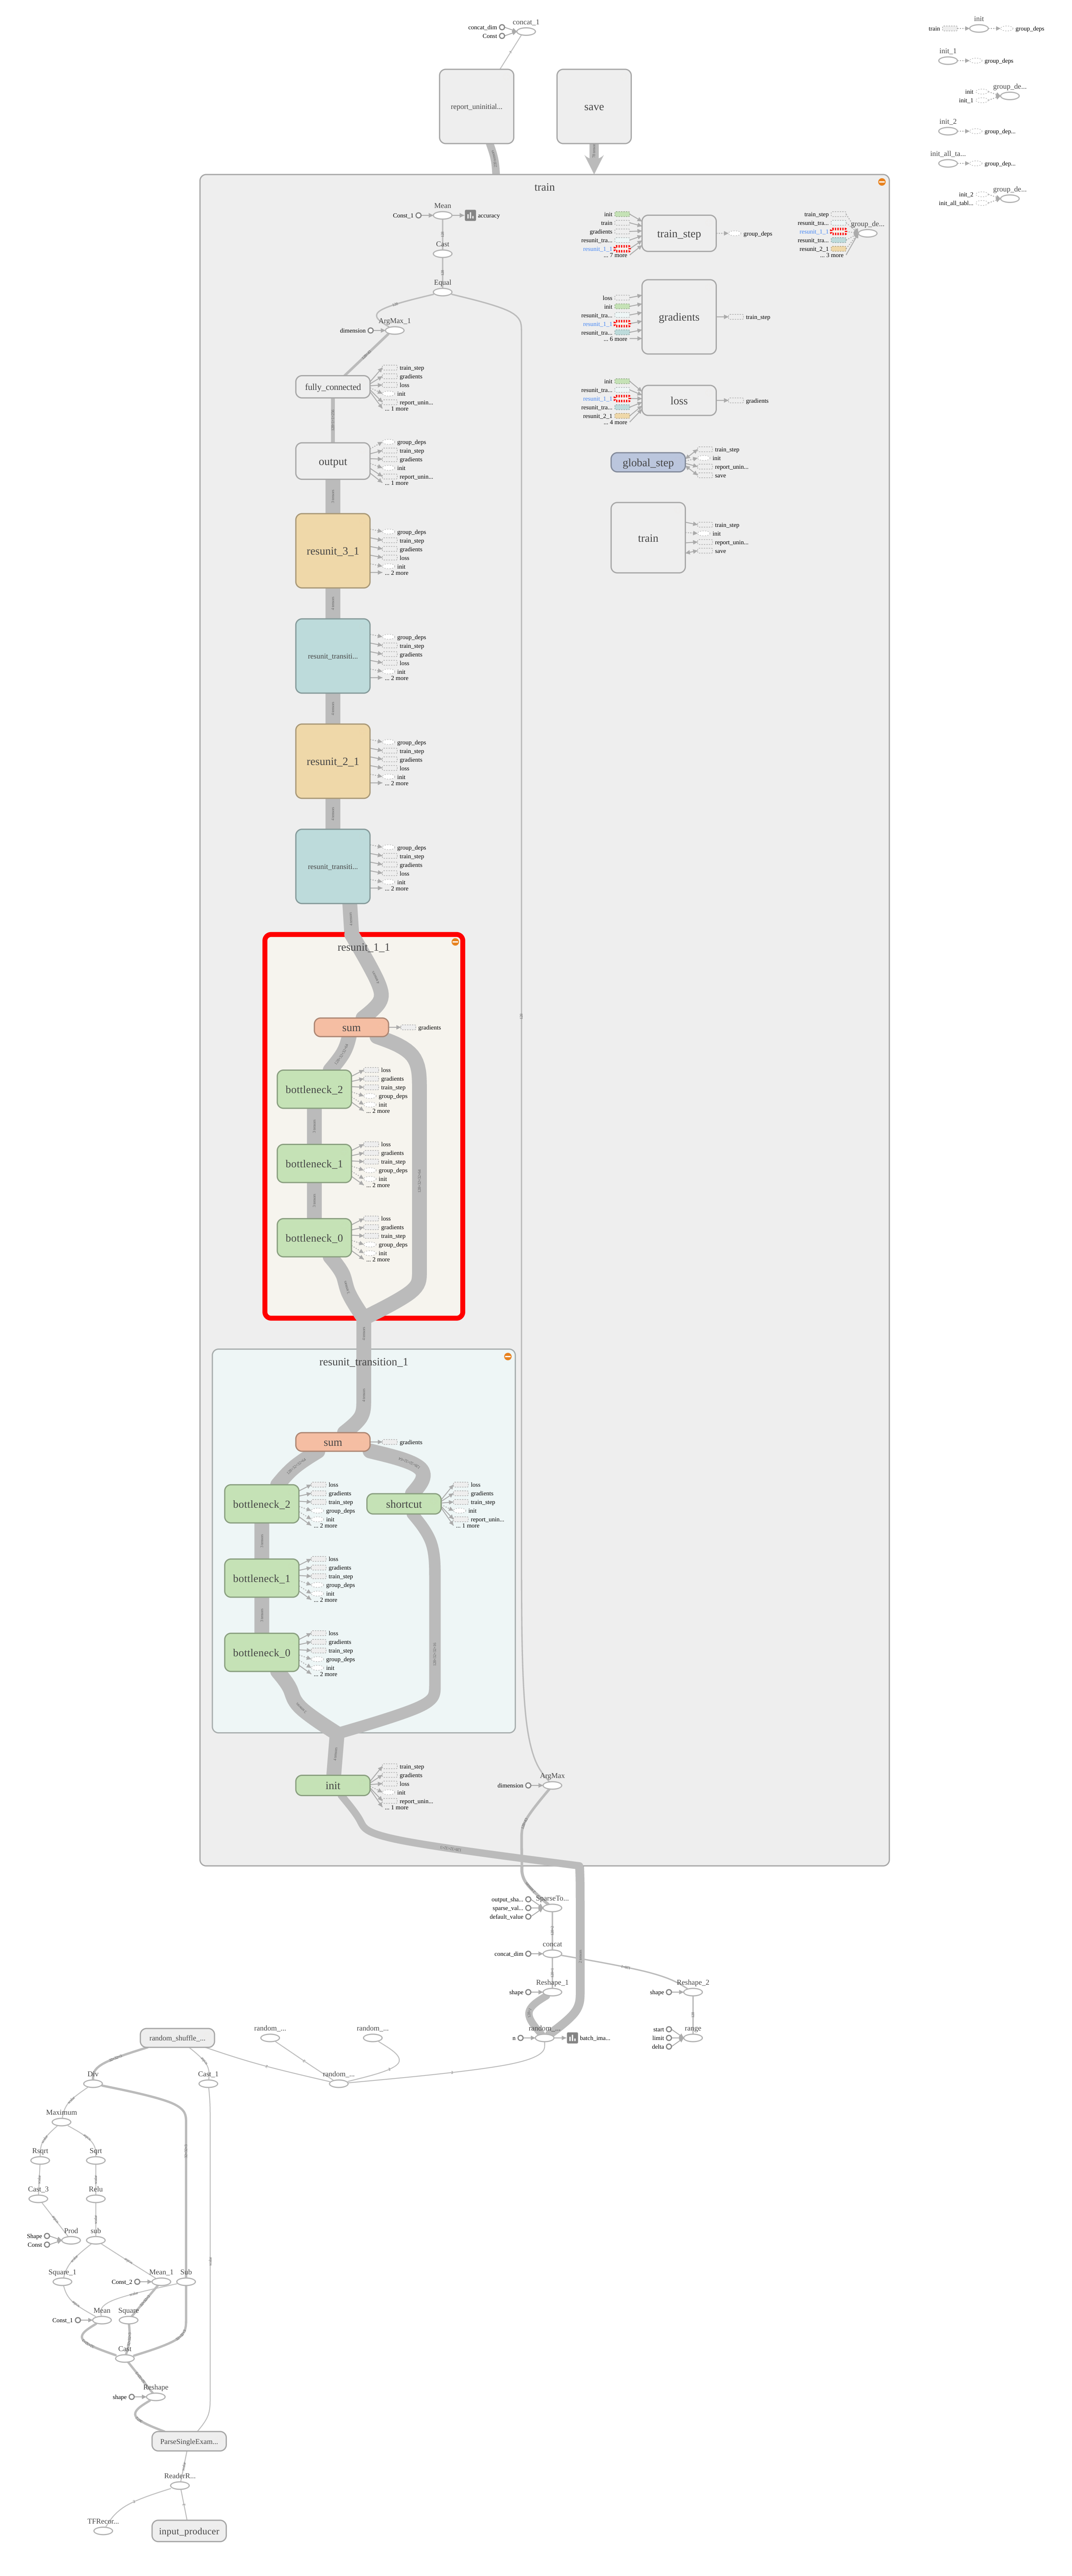

In [29]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

Image(filename="tfdir/model/graph.png")

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.